In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

import cv2
from scipy.signal import convolve2d
from scipy.signal import find_peaks

from utils import *
    
resdir = 'res'

In [2]:
mpl.rcParams['figure.figsize'] = (20, 20)
TASK = 2
if not os.path.exists('{}/{}'.format(resdir, task_dirtree[TASK][0])):
    os.makedirs('{}/{}'.format(resdir, task_dirtree[TASK][0]))

In [3]:
from skimage.feature import peak_local_max

def separate_with_watershed2(th, image, fg=None, bg=None, local_peaks=False, show=False):
    th = ((th > 0) * 255).astype(np.uint8)
    # Noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # FG & BG & UNKNOWN
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 3)
    dist_transform = np.round((dist_transform - dist_transform.min()) / \
                    (dist_transform.max() - dist_transform.min() + 1e-10) * 255).astype(np.uint8)
    if fg is None:
        sure_fg = cv2.morphologyEx(cv2.erode(opening, kernel, iterations=1),
                                   cv2.MORPH_OPEN, kernel, iterations=1)
    else:
        sure_fg = fg
    if bg is None:
        sure_bg = cv2.dilate(opening, kernel, iterations=1)
        if sure_fg.max() == 1:
            sure_fg = (sure_fg*255)
        sure_fg = sure_fg.astype(np.uint8)
    else:
        sure_bg = bg
    if local_peaks:
        sure_fg = peak_local_max(dist_transform, indices=False, footprint=np.ones((21, 21)), labels=th)
        sure_fg = dilate(sure_fg, kernel=3, it=5)
    if sure_fg.max() == 1:
        sure_fg = (sure_fg*255)
    if sure_bg.max() == 1:
        sure_bg = (sure_bg*255)
    sure_fg = sure_fg.astype(np.uint8)
    sure_bg = sure_bg.astype(np.uint8)
    unknown = cv2.subtract(sure_bg, sure_fg).astype(bool) * 255
    
    # MARKERS
    _, markers0 = cv2.connectedComponents(sure_fg)
    markers0 = markers0+1
    markers0[unknown==255] = 0
    
    # WATERSHED
    markers = cv2.watershed(image, markers0)
    image_watershed = image.copy()
    image_watershed[markers == -1] = [255,0,0]
    print("> Found {} objects".format(len(np.unique(markers))-2))
    if show:
        print('  Separation steps:')
        imshow(sure_fg, sub=(1,3,1), title="Foreground")
        imshow(sure_bg, sub=(1,3,2), title="Background")
        imshow(unknown, sub=(1,3,3), title="Unknown")
        plt.show()
        imshow(dist_transform, sub=(1,3,1))
        imshow(markers0, sub=(1,3,1), cmap='jet')
        imshow(markers, sub=(1,3,2), cmap='jet')
        imshow(image_watershed, sub=(1,3,3))
        plt.show()
    
    return markers, image_watershed

Image #1


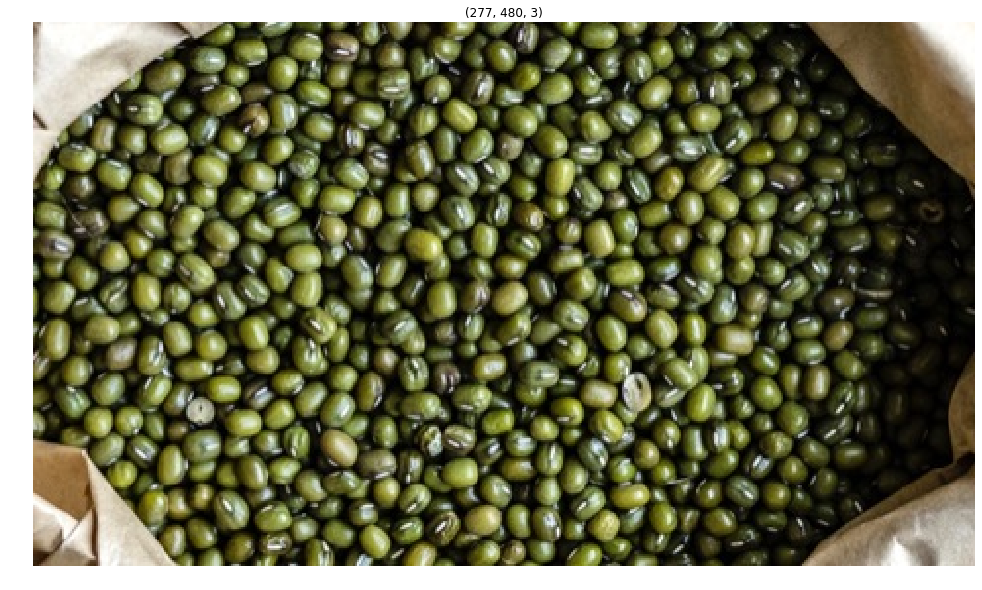

  Segmentation using 2 dominant colors:
> Found 354 objects
  Separation steps:


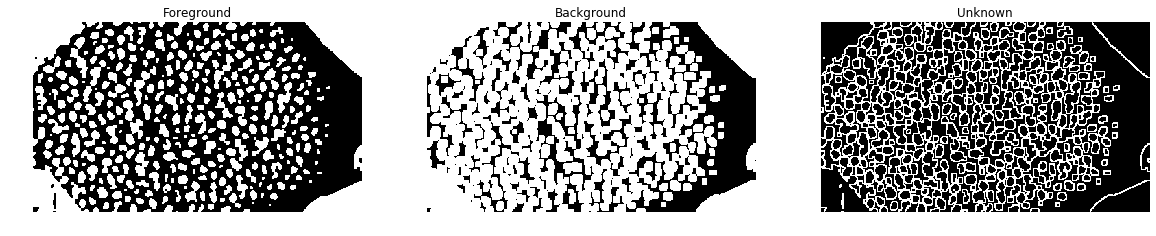

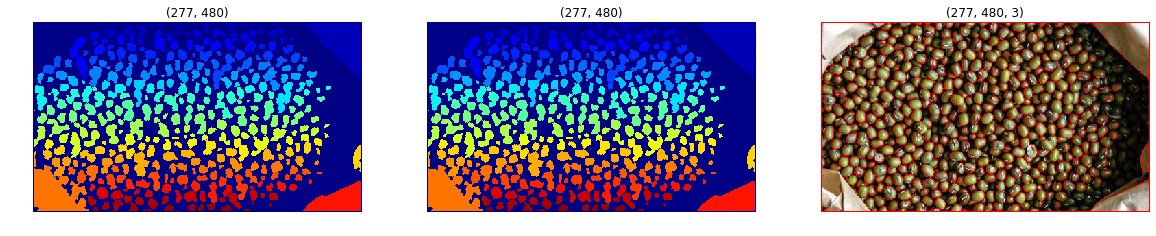

Image #2


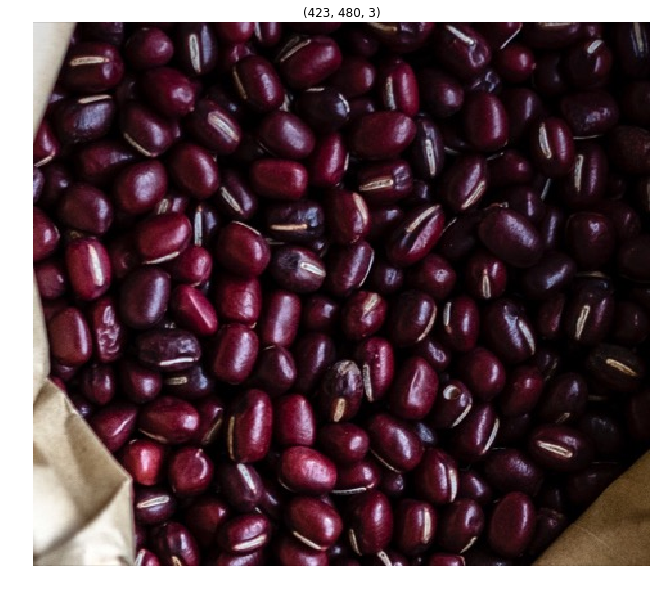

  Segmentation using 2 dominant colors:
> Found 166 objects
  Separation steps:


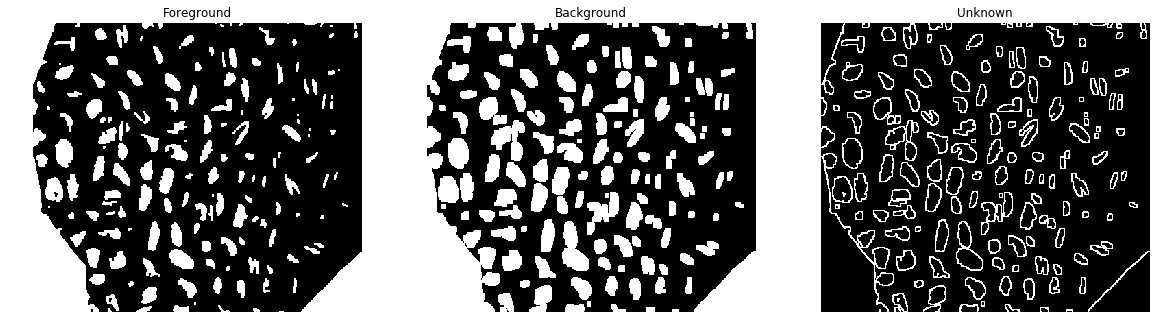

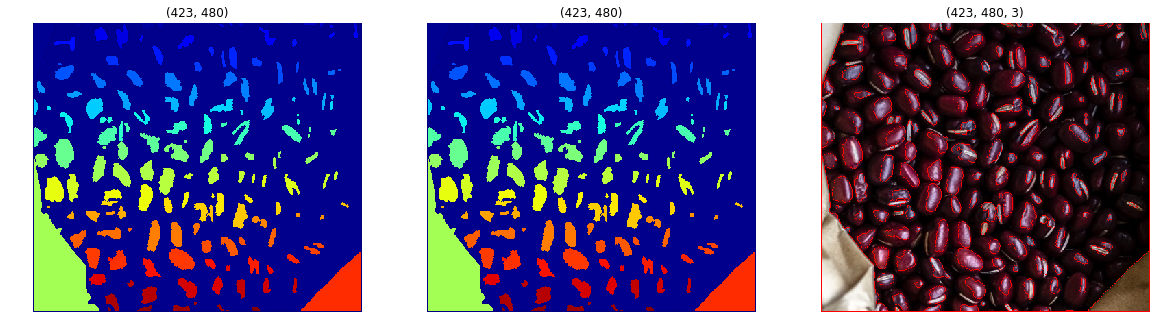

Image #3


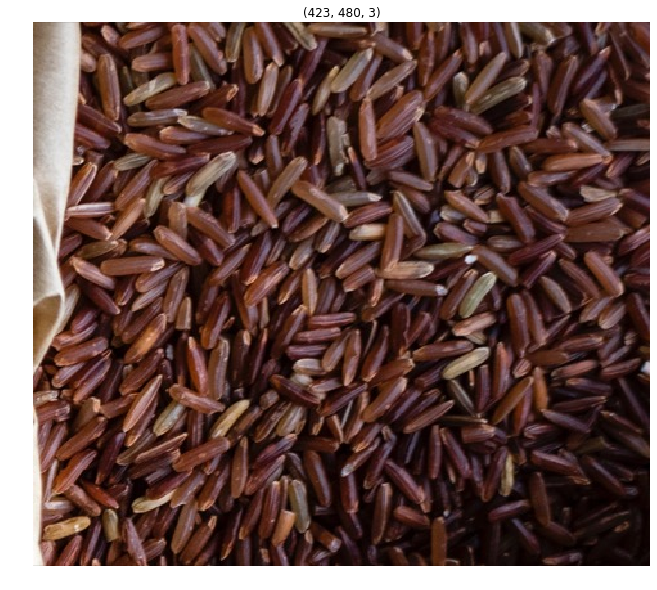

  Segmentation using 2 dominant colors:
> Found 232 objects
  Separation steps:


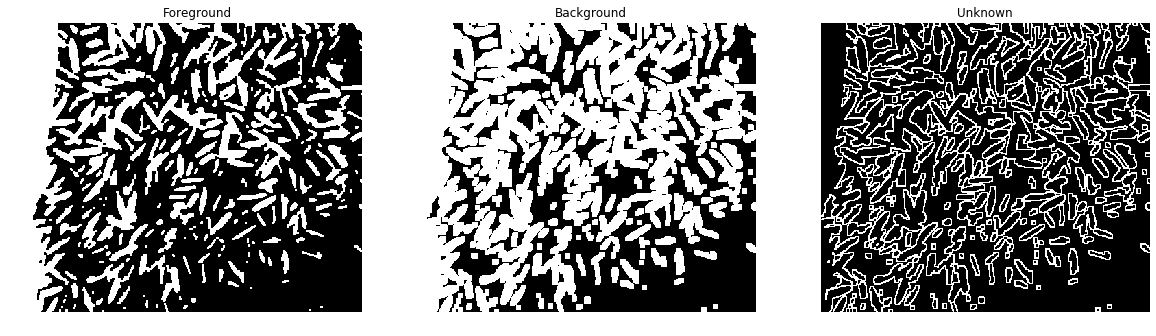

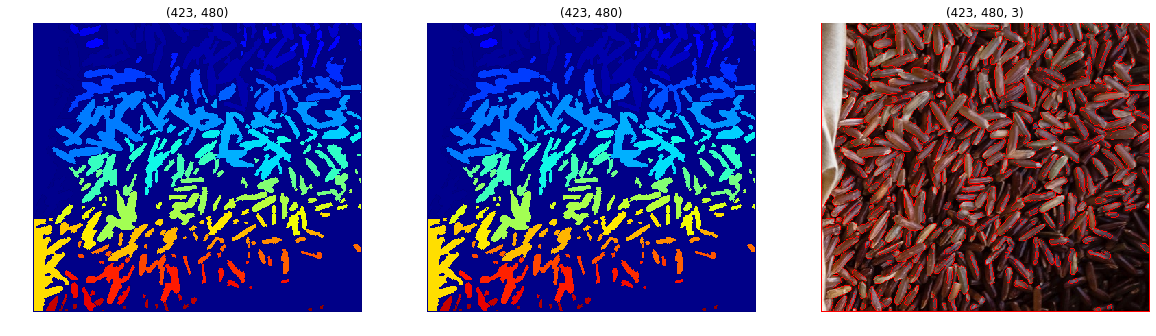

Image #4


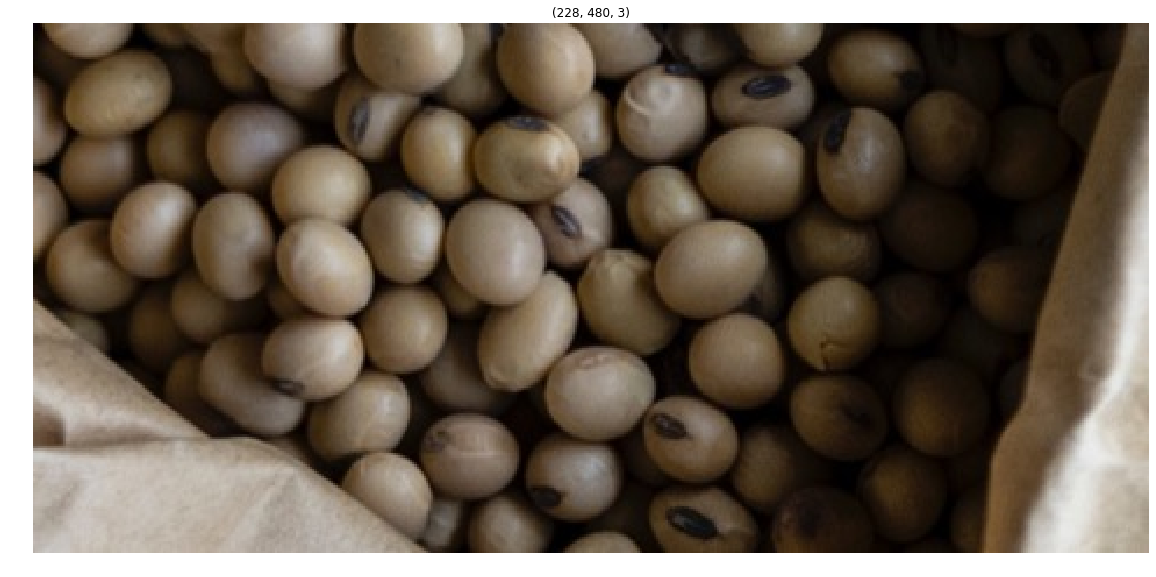

  Segmentation using 2 dominant colors:
> Found 38 objects
  Separation steps:


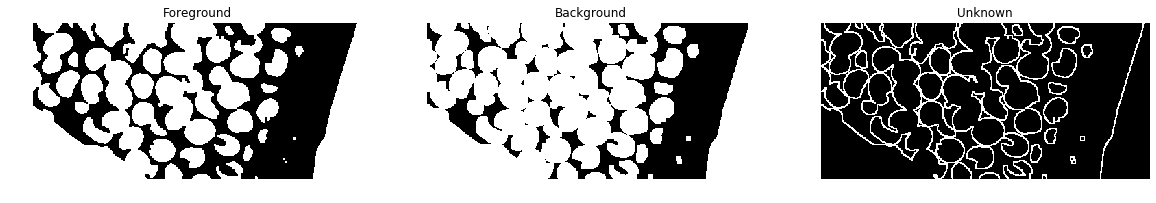

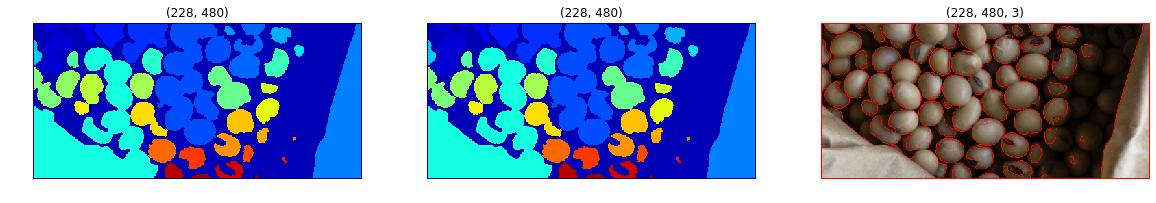

Image #5


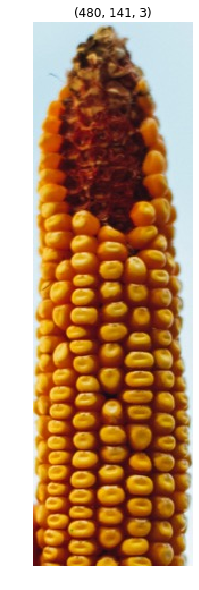

  Segmentation using 2 dominant colors:
> Found 55 objects
  Separation steps:


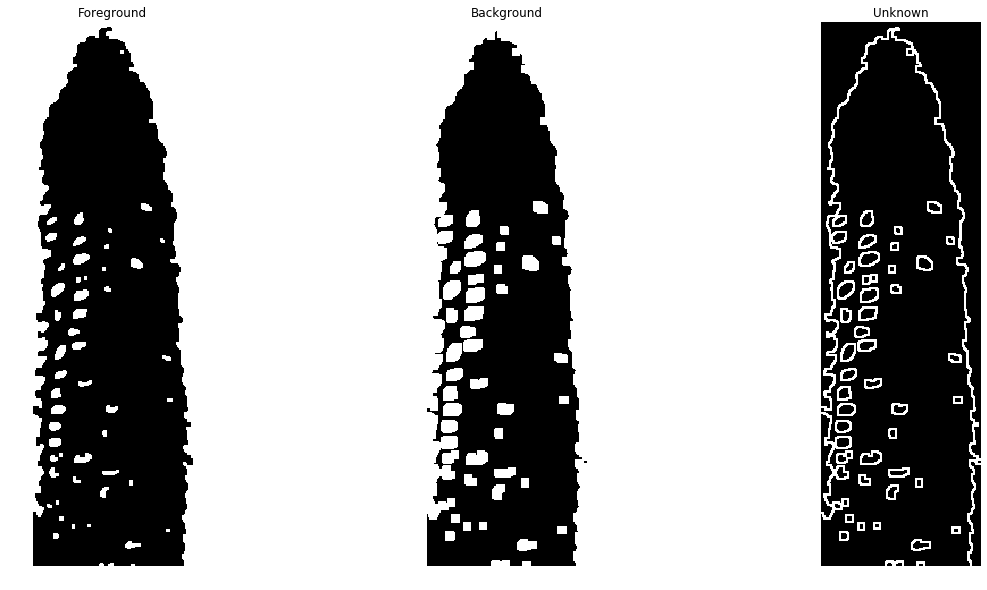

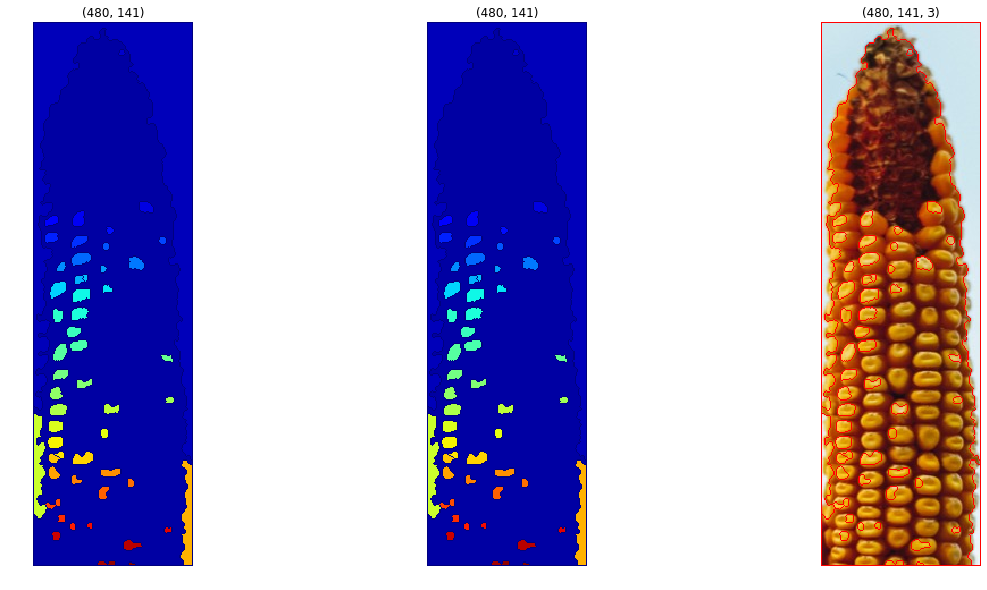

Image #6


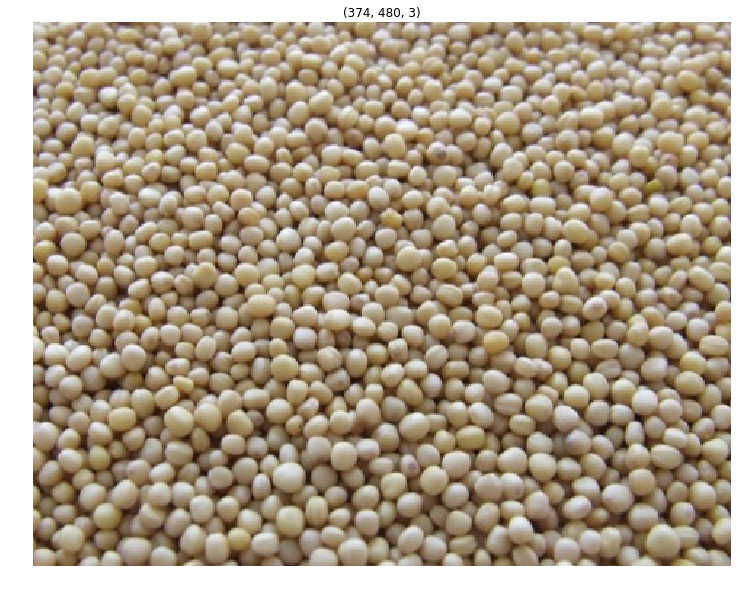

  Segmentation using 2 dominant colors:
> Found 576 objects
  Separation steps:


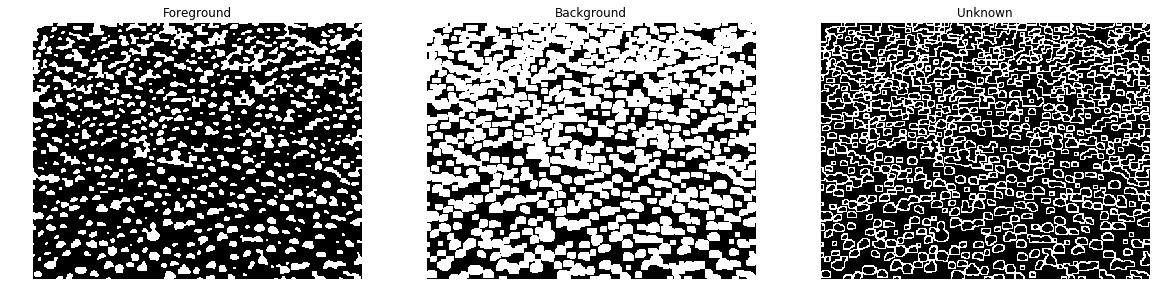

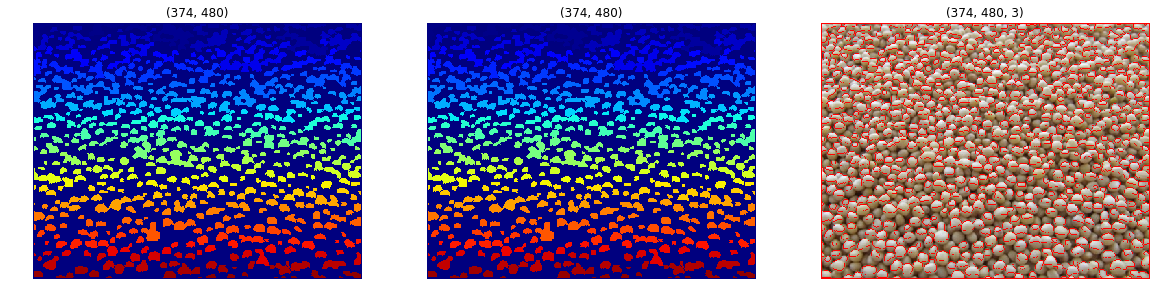

Image #7


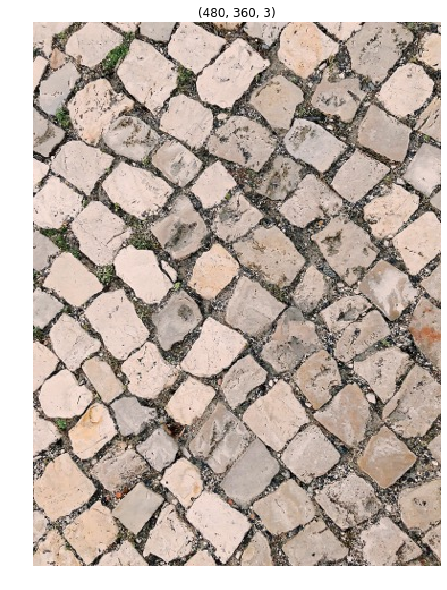

  Segmentation using 2 dominant colors:
> Found 193 objects
  Separation steps:


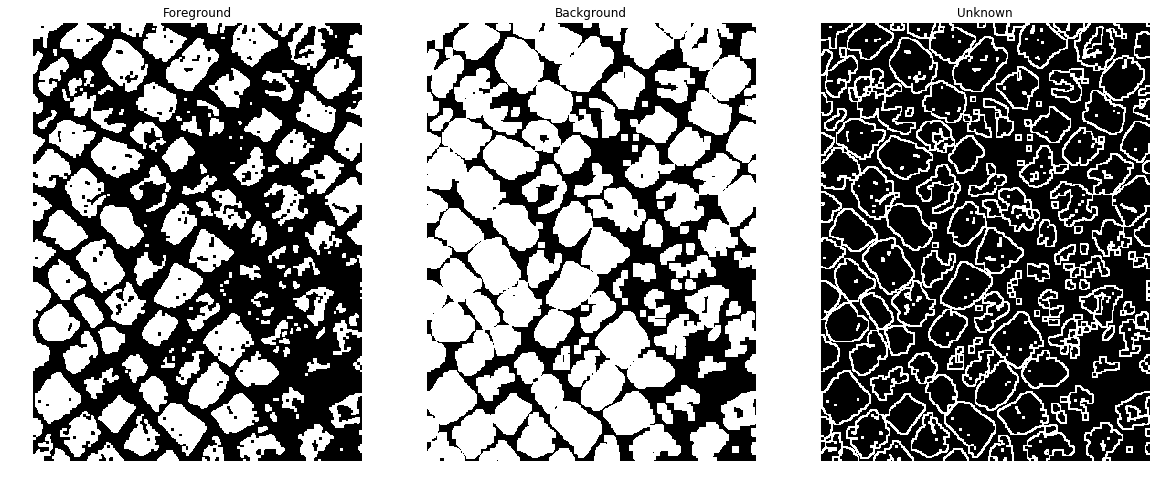

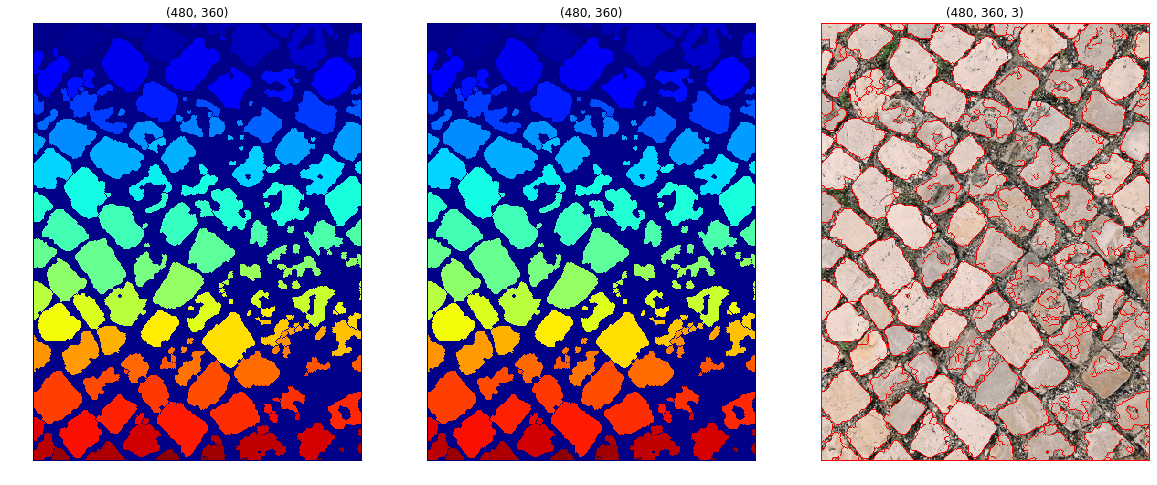

Image #8


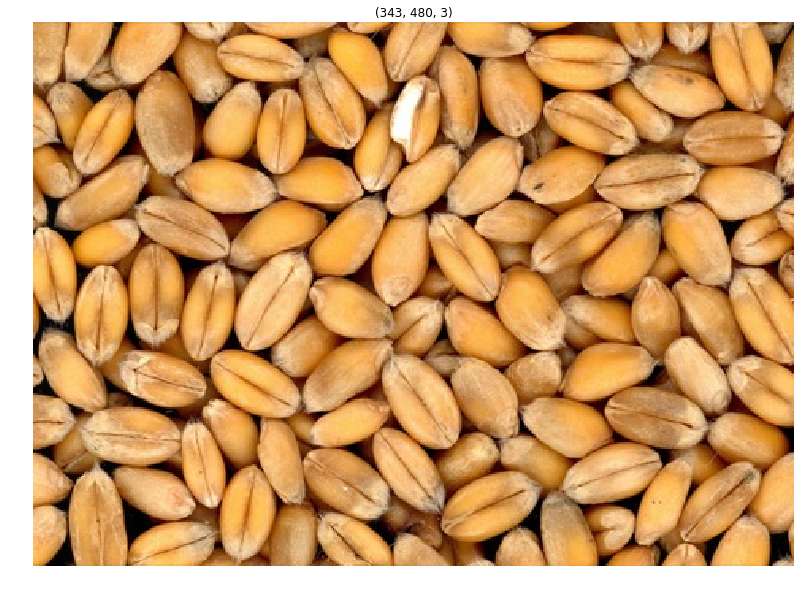

  Segmentation using 2 dominant colors:
> Found 136 objects
  Separation steps:


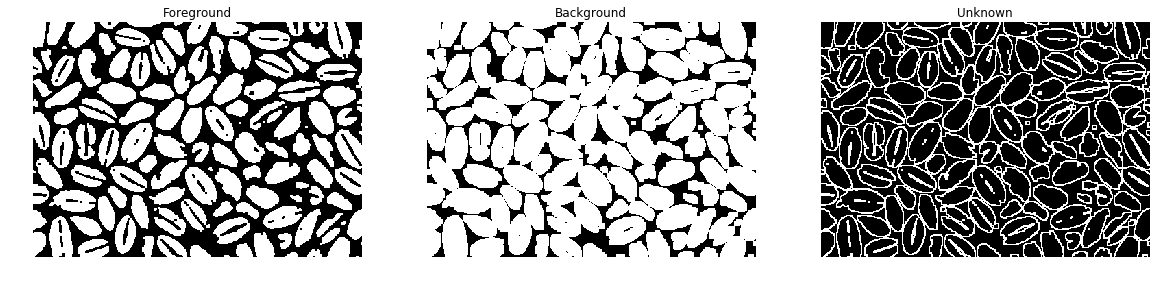

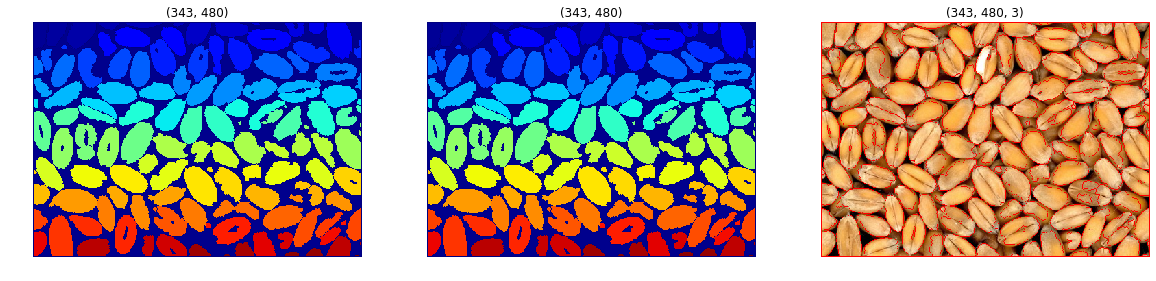

Image #10


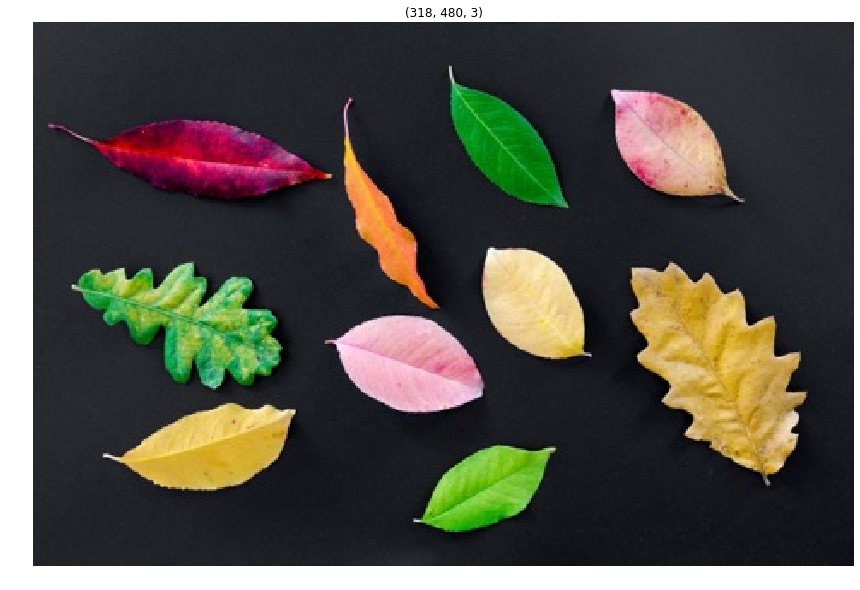

  Segmentation using 2 dominant colors:
> Found 10 objects
  Separation steps:


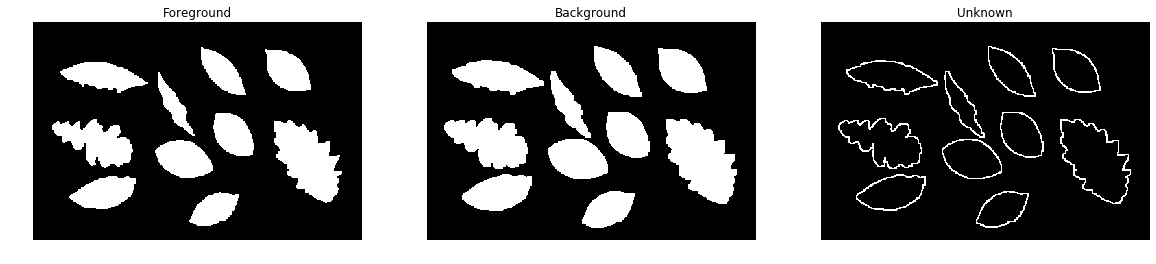

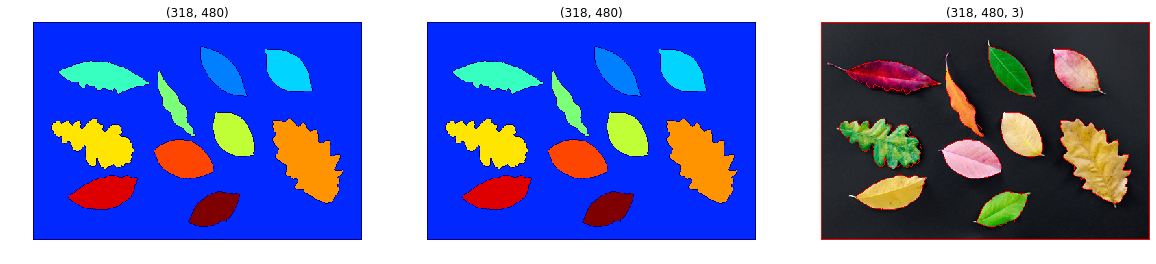

In [16]:
mpl.rcParams['figure.figsize'] = (20, 10)
for example_id in list(np.arange(1,9))+[10]:
    print("Image #{}".format(example_id))
    image, _ = get_example(example_id, TASK, brightness_value=0, show=False)
    image_resized = cv2.resize(image, None, fx=0.2, fy=0.2)
    imshow(image)
    
    # EM
    # Get dominant colors
    show = True
    N_CLUSTERS = 2
    em = cv2.ml.EM_create()
    em.setClustersNumber(N_CLUSTERS)
    em.trainEM(image_resized.reshape((-1,3)))
    means = em.getMeans()
    covs = [np.diag(c) for c in em.getCovs()]
    means_img = np.round(means).astype(np.uint8).reshape(1,N_CLUSTERS,3)
    _, prob = em.predict(np.ﬂoat32(image.reshape((-1,3))))
    image_segmented = means[np.argmax(prob, 1)].reshape(image.shape).astype(np.uint8)
    if show:
        print("  Segmentation using 2 dominant colors:")
        imshow(image_resized, sub=(1,3,1))
        imshow(means_img, sub=(1,3,2))
        imshow(image_segmented, sub=(1,3,3))
    
    # Segment
    segmentation = cv2.threshold(cv2.cvtColor(image_segmented, cv2.COLOR_RGB2GRAY),
                         255, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

    # Hist
#     for i in range(3):
#         y, x = np.histogram(image[:,:,i], bins=51)
#         plt.subplot(1,3,i+1)
#         plt.bar(x[:-1], y)
#     plt.show()
    
    # Threshold
#     threshold = np.ones_like(image.mean(2))
#     print(threshold.shape)
#     for i in range(3):
# #         th = cv2.adaptiveThreshold(image[:,:,i], 255,
# #                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
# #                                   cv2.THRESH_BINARY, 51, 3)
#         _, th = cv2.threshold(image[:,:,i], 255, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#         th = fillHoles(th, 2)
#         imshow(th, sub=(1,3,i+1))
#         print(th.shape)
#         threshold *= th.astype(bool)

    markers, image_watershed = separate_with_watershed2(segmentation, image, show=show)
    save(markers, TASK, "{}_watershed_markers".format(example_id), cmap='jet')
    save(image_watershed, TASK, "{}_watershed".format(example_id))
#     break

Image #9


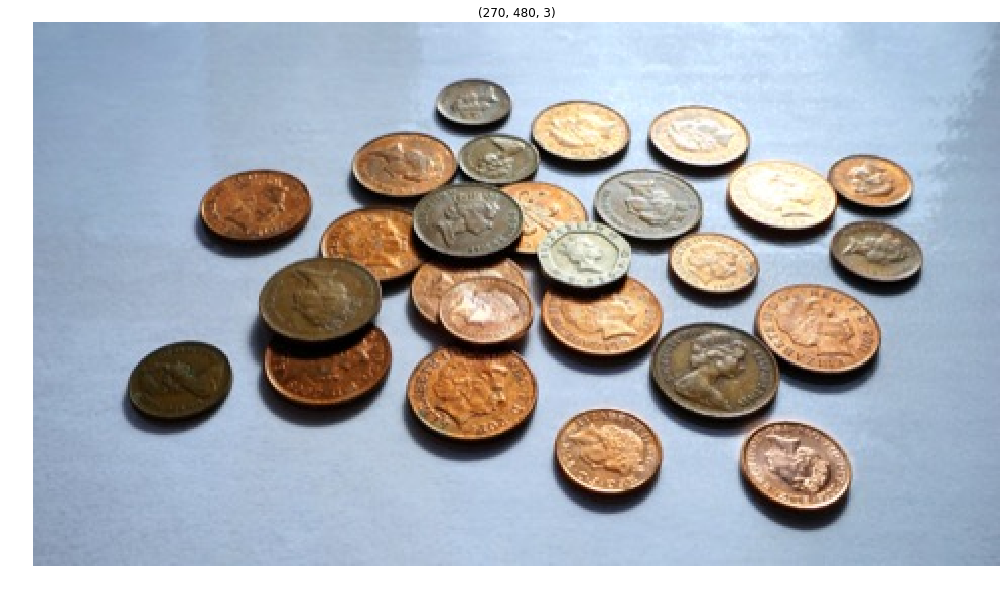

> Found 27 objects
  Separation steps:


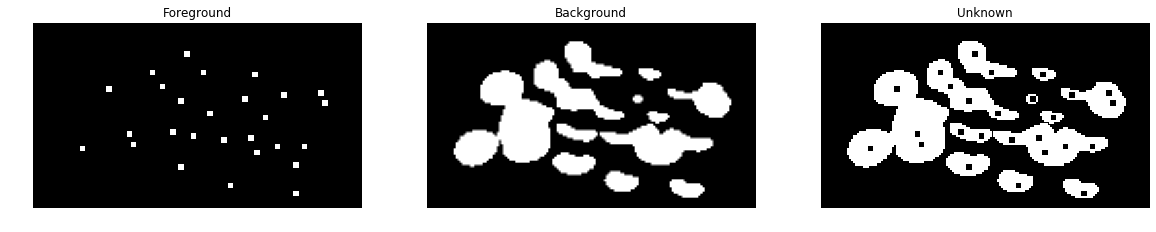

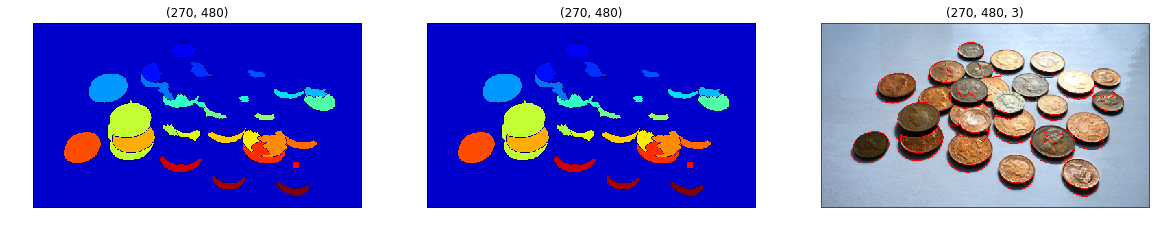

Image #11


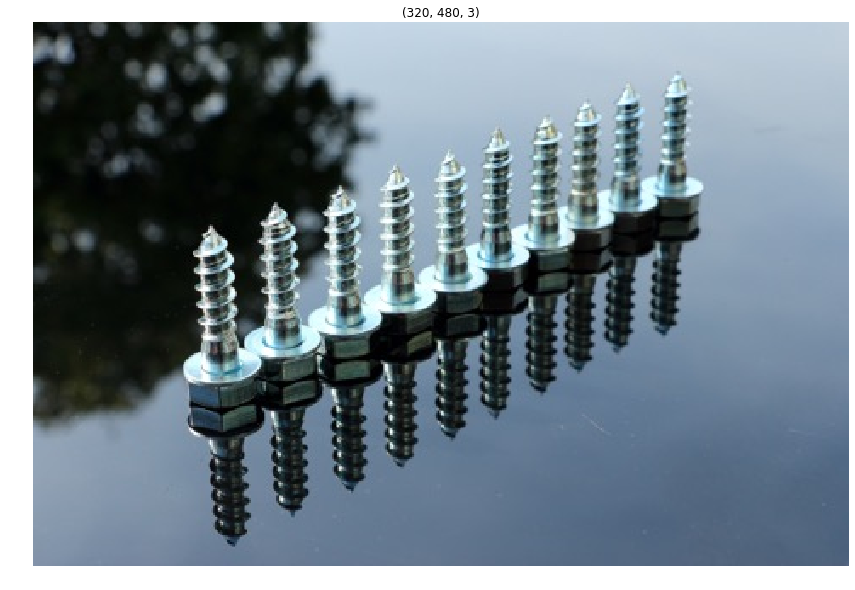

> Found 10 objects
  Separation steps:


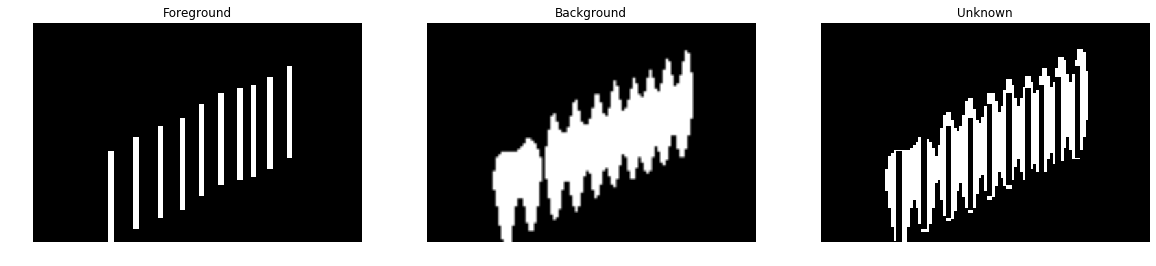

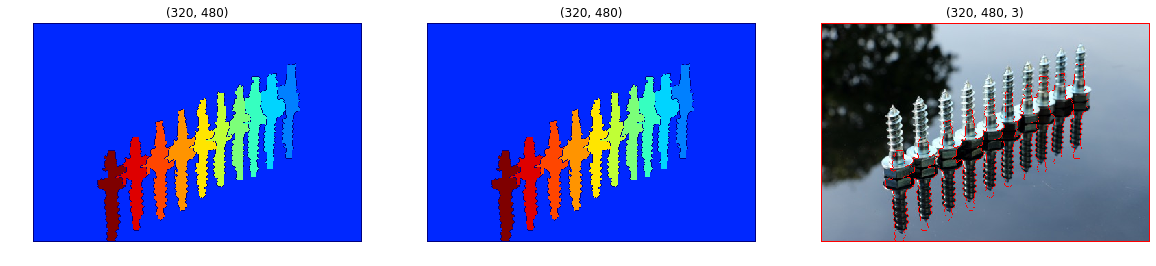

Image #12


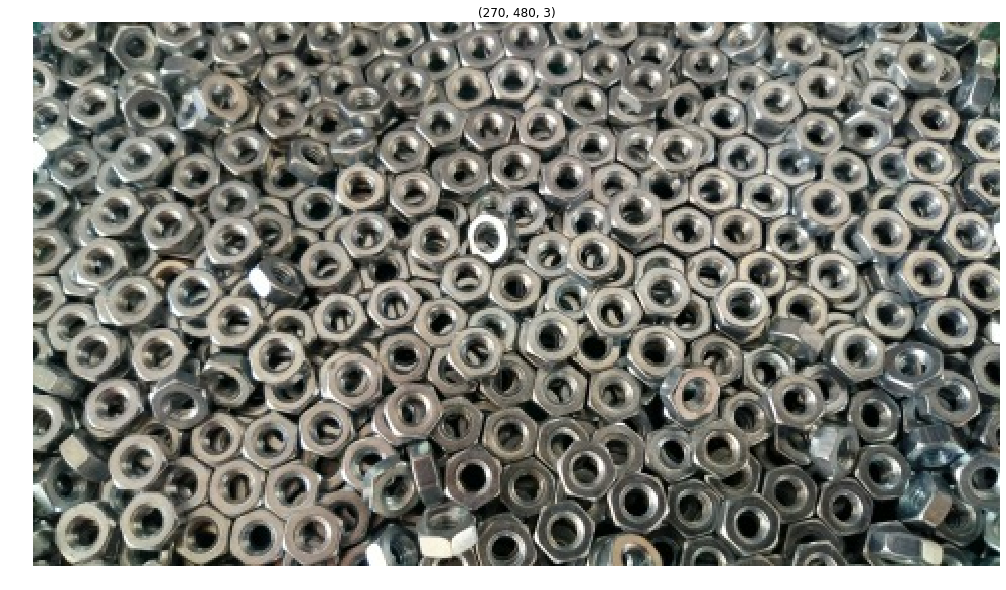

> Found 146 objects
  Separation steps:


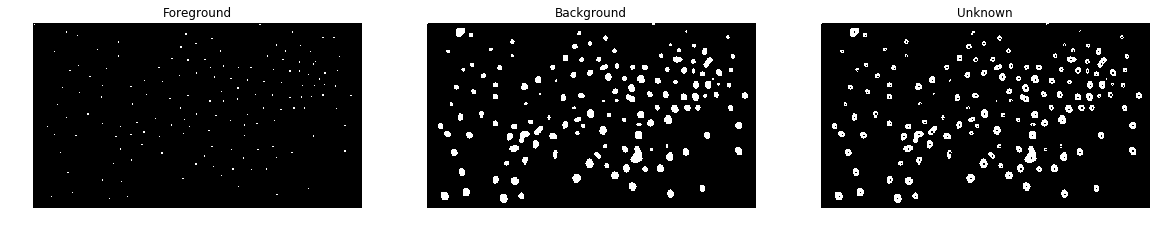

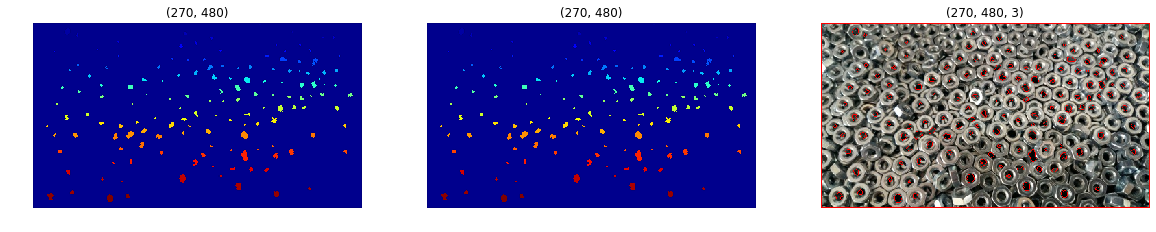

In [15]:
mpl.rcParams['figure.figsize'] = (20, 10)
K = 39
CUT = K//2

kernels_for_specific_examples = [
    {1: gaussian_kernel(K, np.array([[5,0],[0,7]], np.uint8)),
     2: np.ones((2,2)),
     'iter': 3,
     'resize_factor': 3
    },
    {1: gaussian_kernel(K, np.array([[71,0],[0,1.5]])),
     2: np.array([[0,0,0,1,0,0,0]]*7, np.uint8),
     'iter': 21,
     'resize_factor': 4
    },
    {1: gaussian_kernel(K, np.array([[5,0],[0,5]])),
     2: np.ones((2,2)),
     'iter': 1,
     'resize_factor': 1
    },
]

for i, example_id in enumerate([9,11,12]):
    show = True
    print("Image #{}".format(example_id))
    image, _ = get_example(example_id, TASK, brightness_value=0, show=False)
    imshow(image)

    # Segment
    segmentation = cv2.adaptiveThreshold(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), 255,
                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv2.THRESH_BINARY, 181, 0)
    # Fill holes
    h, w = segmentation.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    for y in range(0,h,5):
        cv2.floodFill(segmentation, mask, (5,y), 255)
        cv2.floodFill(segmentation, mask, (w-5,y), 255)
    for x in range(0,w,5):
        cv2.floodFill(segmentation, mask, (x,5), 255)
        cv2.floodFill(segmentation, mask, (x,h-5), 255)
    segmentation = ((cv2.GaussianBlur(255 - segmentation, (7,7), 5) > 210)*255).astype(np.uint8)
    kernel = kernels_for_specific_examples[i][1]
    RESIZE_FACTOR = kernels_for_specific_examples[i]['resize_factor']
    blurred = convolve2d(cv2.resize(segmentation, None, fx=1/RESIZE_FACTOR, fy=1/RESIZE_FACTOR), kernel)[CUT:-CUT,CUT:-CUT]
    blurred = blurred * (blurred > 40)
    fg = peak_local_max(blurred, indices=False)
    fg = (fg * 255).astype(np.uint8)
    fg = cv2.resize(fg, None, fx=RESIZE_FACTOR, fy=RESIZE_FACTOR)
    fg = cv2.dilate(fg, kernels_for_specific_examples[i][2], iterations=kernels_for_specific_examples[i]['iter'])
    fg = fg > 0
    segmentation = ((blurred > 50) * 255).astype(np.uint8)
    segmentation = cv2.resize(segmentation, None, fx=RESIZE_FACTOR, fy=RESIZE_FACTOR)
    bg = segmentation

    markers, image_watershed = separate_with_watershed2(segmentation, image, show=show, local_peaks=False, fg=fg, bg=bg)
    save(markers, TASK, "{}_watershed_markers".format(example_id), cmap='jet')
    save(image_watershed, TASK, "{}_watershed".format(example_id))